# GANs implementation in Python on MNIST Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

## Defining the model structure

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.0005
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 100

In [ ]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

## Training the model

In [ ]:
list_fake = []
list_real = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                list_fake.append(fake)
                list_real.append(data)


Epoch [0/100] Batch 0/1875 Loss D: 0.6931, loss G: 0.7291
Epoch [1/100] Batch 0/1875 Loss D: 0.3272, loss G: 1.5985
Epoch [2/100] Batch 0/1875 Loss D: 0.4901, loss G: 1.4395
Epoch [3/100] Batch 0/1875 Loss D: 0.7874, loss G: 1.1794
Epoch [4/100] Batch 0/1875 Loss D: 0.6721, loss G: 0.8867
Epoch [5/100] Batch 0/1875 Loss D: 0.7818, loss G: 0.8974
Epoch [6/100] Batch 0/1875 Loss D: 0.4897, loss G: 1.4672
Epoch [7/100] Batch 0/1875 Loss D: 0.5475, loss G: 1.0188
Epoch [8/100] Batch 0/1875 Loss D: 0.3973, loss G: 1.6384
Epoch [9/100] Batch 0/1875 Loss D: 0.7589, loss G: 1.1913
Epoch [10/100] Batch 0/1875 Loss D: 0.4237, loss G: 1.4066
Epoch [11/100] Batch 0/1875 Loss D: 0.7145, loss G: 1.1535
Epoch [12/100] Batch 0/1875 Loss D: 0.7579, loss G: 1.3619
Epoch [13/100] Batch 0/1875 Loss D: 0.7512, loss G: 1.4940
Epoch [14/100] Batch 0/1875 Loss D: 0.7505, loss G: 0.9871
Epoch [15/100] Batch 0/1875 Loss D: 0.5026, loss G: 1.3227
Epoch [16/100] Batch 0/1875 Loss D: 0.5768, loss G: 1.1354
Epoch [

In [ ]:
img_real = real.detach().cpu().numpy()
img_fake = fake.detach().cpu().numpy()

# Testing the outputs

Some Real Images


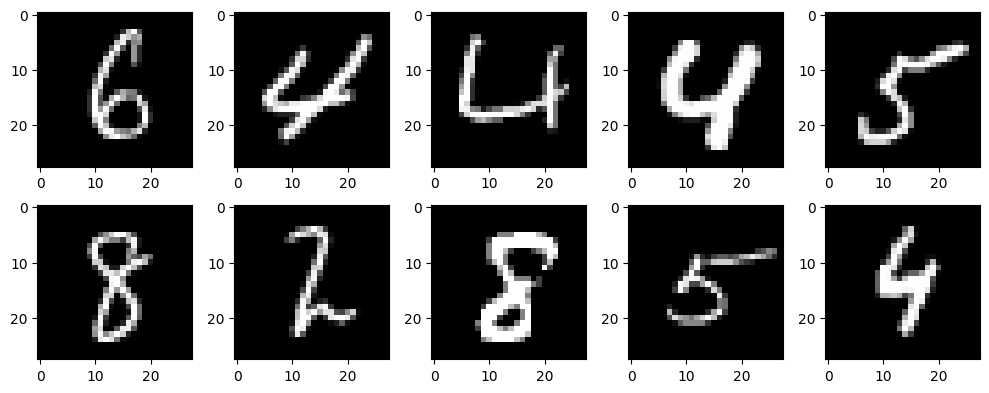

In [ ]:
print('Some Real Images')
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    current_image_real = img_real[i].reshape((28, 28)) * 255
    plt.gray()


    row = i // 5
    col = i % 5

    axs[row, col].imshow(current_image_real, interpolation='nearest')

plt.tight_layout()
plt.show()




Some Fake Images


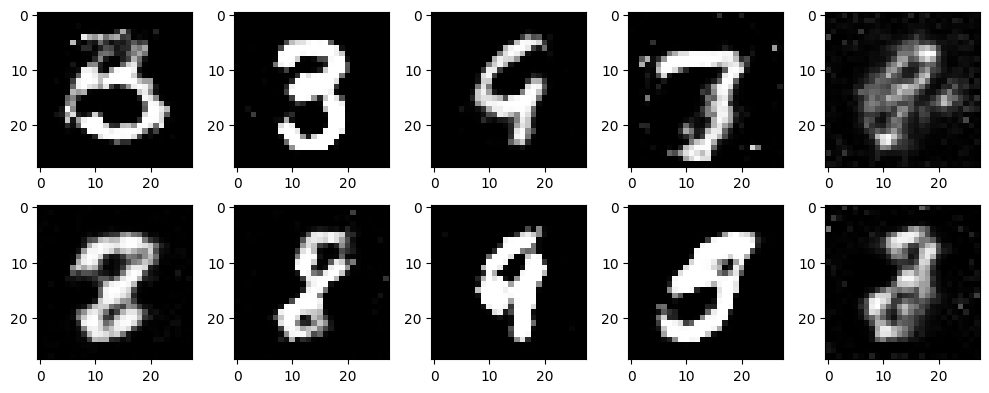

In [ ]:
print('Some Fake Images')
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    current_image_fake = img_fake[i].reshape((28, 28)) * 255
    plt.gray()

    row = i // 5
    col = i % 5

    axs[row, col].imshow(current_image_fake, interpolation='nearest')

plt.tight_layout()
plt.show()